In [57]:
import numpy as np
import qiskit 
from qiskit import transpile, assemble,IBMQ
from qiskit.visualization import *
from qiskit.extensions import  UnitaryGate

#IBMQ.delete_accounts()
#IBMQ.save_account('2d7fb4a2d08cbb349872fe2229939996c6b01d6e420a129f9a63a5c8bb7c615394c422b44240dc09c275e506c6bad13d80776785cbfb36ef2e6ac297c9b85715')
#IBMQ.load_account()

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch.nn.parameter import Parameter

In [58]:
#set parameter
interest_num = [3,6,7]
class_num = len(interest_num)
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 8
inference_batch_size = 1

In [59]:
# Weiwen: modify the target classes starting from 0. Say, [3,6] -> [0,1]
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    new_target = torch.zeros(target.shape[0],2)
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

# Weiwen: select sub-set from MNIST
def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    dataset.targets,_ = modify_target(dataset.targets)
    return dataset

In [60]:
################ Weiwen on 12-30-2020 ################
# Using torch to load MNIST data
######################################################

# convert data to torch.float64Tensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)

In [61]:

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum data
######################################################
class ToQuantumData(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v),)
        output_data = output_matrix[:, 0].view(1, img_size,img_size)
        return output_data

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum matrix
######################################################
class ToQuantumMatrix(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v), dtype=torch.float64)
        return output_matrix   

################ Weiwen on 12-30-2020 ################
# T1: Downsample the image from 28*28 to 4*4
# T2: Convert classical data to quantum data which 
#     can be encoded to the quantum states (amplitude)
######################################################

# Process data by hand, we can also integrate ToQuantumData into transform
def data_pre_pro(img):
    # Print original figure
    img = img
    npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    #plt.show()
    # Print resized figure
    image = np.asarray(npimg[0] * 255, np.uint8)    
    im = Image.fromarray(image,mode="L")
    im = im.resize((4,4),Image.BILINEAR)    
    #plt.imshow(im,cmap='gray',)
    #plt.show()
    # Converting classical data to quantum data
    trans_to_tensor = transforms.ToTensor()
    trans_to_vector = ToQuantumData()
    trans_to_matrix = ToQuantumMatrix()    
    #print("Classical Data: {}".format(trans_to_tensor(im).flatten()))
    #print("Quantum Data: {}".format(trans_to_vector(trans_to_tensor(im)).flatten()))
    return trans_to_matrix(trans_to_tensor(im)),trans_to_vector(trans_to_tensor(im))

# Use the first image from test loader as example
global g_quantum_matrix
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    g_quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
    break
  

Batch Id: 0, Target: tensor([0])


In [62]:
#draft 
a = {"1":3,"2":6}
def func(l):
    b = l
    b["2"] = 7

func(a)
print (a)

{'1': 3, '2': 7}


In [63]:
################ zhirui on 12-30-2020 ################
# this block is for buding variant circuit
######################################################
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

class VQuantumCircuit:    
    def __init__(self, n_qubits, backend, shots):
        # --- parameter definition ---
        #self._circuit = circuit
        self.n_qubits = n_qubits
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.ParameterVector('theta',n_qubits*2)
        self.theta = list(self.theta)
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    #define the circuit
    def vqc_10(self,circuit):

        #head ry part 
        for i in range(0,self.n_qubits):
            circuit.ry(self.theta[i], i)
        circuit.barrier()
        
        #cz part
        for i in range(self.n_qubits-1):
            circuit.cz(self.n_qubits-2-i,self.n_qubits-1-i)
        circuit.cz(0,self.n_qubits-1)
        circuit.barrier()

        #tail ry part
        for i in range(0,self.n_qubits):
            circuit.ry(self.theta[i+self.n_qubits], i)     


    
    def build(self,circuit):
        self.vqc_10(circuit)
    
    def run(self,circuit, thetas):
    #define the whole circuit
        circuit.measure_all()

        t_qc = transpile(circuit,
                         self.backend)
        binds = {}
        for i in range(0,len(thetas)):#
            binds[self.theta[i]]= thetas[i]

        

        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [binds]
                        )
        job = self.backend.run(qobj)

        result = job.result().get_counts()
        # print("result:",result)

        #counts = np.array(list(result.values()))
        #states = np.array(list(result.keys())).astype(float)
        # Compute probabilities for each state
        output = np.zeros(4)
        for key in result.keys():
          result[key] =  result[key] / self.shots
          i=0
          for c in key:
              if c == '1':
                  output[i] =output[i]+ result[key]
              i = i+1
        return output


simulator = qiskit.Aer.get_backend('aer_simulator')
vqc = VQuantumCircuit(4, simulator, 10000)

# print("g_quantum_matrix:",g_quantum_matrix)
circuit = qiskit.QuantumCircuit(4)
circuit.append(UnitaryGate(g_quantum_matrix, label="Input"),range(0,4))
vqc.build(circuit)
print('probabilities :{}'.format(vqc.run(circuit,[np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2])))
circuit.draw()


probabilities :[0.5871 0.9729 0.9113 0.4095]


┌────────┐┌──────────────┐ ░              ░ ┌──────────────┐ ░ ┌─┐   »
   q_0: ┤0       ├┤ Ry(theta[0]) ├─░────────■──■──░─┤ Ry(theta[4]) ├─░─┤M├───»
        │        │├──────────────┤ ░        │  │  ░ ├──────────────┤ ░ └╥┘┌─┐»
   q_1: ┤1       ├┤ Ry(theta[1]) ├─░─────■──■──┼──░─┤ Ry(theta[5]) ├─░──╫─┤M├»
        │  Input │├──────────────┤ ░     │     │  ░ ├──────────────┤ ░  ║ └╥┘»
   q_2: ┤2       ├┤ Ry(theta[2]) ├─░──■──■─────┼──░─┤ Ry(theta[6]) ├─░──╫──╫─»
        │        │├──────────────┤ ░  │        │  ░ ├──────────────┤ ░  ║  ║ »
   q_3: ┤3       ├┤ Ry(theta[3]) ├─░──■────────■──░─┤ Ry(theta[7]) ├─░──╫──╫─»
        └────────┘└──────────────┘ ░              ░ └──────────────┘ ░  ║  ║ »
meas: 4/════════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
«              
«   q_0: ──────
«              
«   q_1: ──────
«        ┌─┐   
«   q_2: ┤M├───
«        └╥┘┌─┐
«   q_3: ─╫─┤M├
«         ║ └╥┘
«meas: 4/═╩══╩═
«         2  3

In [64]:
identity = torch.tensor([[1,0],[0,1]])
mat2 = torch.tensor([[1,2],[3,4]])
print(torch.kron(identity,mat2))
print(torch.kron(mat2,identity))

tensor([[1, 2, 0, 0],
        [3, 4, 0, 0],
        [0, 0, 1, 2],
        [0, 0, 3, 4]])
tensor([[1, 0, 2, 0],
        [0, 1, 0, 2],
        [3, 0, 4, 0],
        [0, 3, 0, 4]])


In [65]:
################ zhirui on 12-30-2020 ################
# this block is for buding the matrix of variant circuit
######################################################
import math
class VClassicCircuitMatrix:
    def __init__(self, n_qubits):
        # --- parameter definition ---
        self._n_qubits = n_qubits
        #state = state
        #constant matrix
        self.mat_cz = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
        self.mat_identity = torch.tensor([[1,0],[0,1]])
        self.mat_swap = torch.tensor([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

    def set_value(self,mm,col,row,val):
        index = (torch.LongTensor([col]),torch.LongTensor([row]))#生成索引
        #value = torch.Tensor(val) #生成要填充的值
        mm = mm.index_put(index ,val)
        return mm

    def get_ry_matrix(self,theta):
        mm = torch.zeros(2,2,dtype=torch.float64)
        mm = self.set_value(mm,0,0,torch.cos(theta/2))
        mm = self.set_value(mm,0,1,-torch.sin(theta/2))
        mm = self.set_value(mm,1,0,torch.sin(theta/2))
        mm = self.set_value(mm,1,1,torch.cos(theta/2))
        return mm

    #swap (index) and (index-1)        
    def qf_swap_dec(self,state,index):
        #generate the matrix
        temp_mat = torch.ones(1,dtype=torch.float64)
        for i in range(0,index-1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)
        temp_mat =torch.kron(self.mat_swap,temp_mat)
        for i in range(0,self._n_qubits-1-index):
            temp_mat = torch.kron(self.mat_identity,temp_mat)
        #change state
        state = torch.mm(temp_mat,state) 
        return state 


    def qf_ry(self,state,theta,index):
        # print("theta 01 :", theta)
        # print("index 01 :",index)
        # print("01:",theta.requires_grad)
        temp_mat = torch.ones(1,dtype=torch.float64)
        if isinstance(index,int): 
            for i in range(0,self._n_qubits):
                if i == index:
                    mm = self.get_ry_matrix(theta)
                    temp_mat = torch.kron(mm,temp_mat) 
                    # print("temp_mat 04 :", temp_mat)  
                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
                    # print("temp_mat 05 :", temp_mat)
        else:
            for i in range(0,self._n_qubits):
                if i in index:
                    select_theta = torch.index_select(theta,0,torch.tensor([i]))
                    select_mm = self.get_ry_matrix(select_theta)
                    temp_mat = torch.kron(select_mm,temp_mat)
                    # print("02:",temp_mat.requires_grad)
                    # print("temp_mat 02 :", temp_mat)
                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
                    # print("temp_mat 03 :", temp_mat)
        #change state
        #print('shape :',temp_mat.shape,' ',state.shape)
        # print("temp_mat 01 :", temp_mat)
        # print("03:",temp_mat.requires_grad)
        state = torch.mm(temp_mat,state)   
        # print("04:",state.requires_grad)
        # print("state 06 :", state)
        return state
     
            
    def qf_cz(self,state,index1,index2):

        #generate the matrix
        
        #swap the bottom one next to the up one
        for i in range(index2,index1+1,-1):
            state = self.qf_swap_dec(state,i)
        
        #generate cz matrix
        temp_mat = torch.ones(1,dtype=torch.float64)
        for i in range(0,index1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)

        temp_mat =torch.kron(self.mat_cz,temp_mat)

        for i in range(0,self._n_qubits-2-index1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)

        #change state
        state = torch.mm(temp_mat,state)   

        #swap back
        for i in range(index1+2,index2+1):
            state = self.qf_swap_dec(state,i)

        return state

    #get the matrix transforming 16 output to 4 output.     
    def qf_sum(self):
        sum_mat = []
        flag = "0"+str(self._n_qubits)+"b"
        for i in range(0,int(math.pow(2,self._n_qubits))):
            bit_str = format(i,flag)
            row = []
            for c in bit_str:
                row.append(float(c))
            sum_mat.append(row)
        return sum_mat


    #the code is similar to the VQuantumCircuit::vqc_10
    def vqc_10(self,state,thetas):
        
        #head ry part 
        # print("05:",state.requires_grad)
        state = self.qf_ry(state,thetas[0:self._n_qubits],range(0,self._n_qubits))
        # print("06:",state.requires_grad)

        #cz part

        for i in range(self._n_qubits-1):
            state = self.qf_cz(state,self._n_qubits-2-i,self._n_qubits-1-i)
        state = self.qf_cz(state,0,self._n_qubits-1)
        # print("07:",state.requires_grad)

        # print("state 04 :", state)

        #tail ry part

        state = self.qf_ry(state,thetas[self._n_qubits:2*self._n_qubits],range(0,self._n_qubits))
        # print("08:",state.requires_grad)

        # print("state 05 :", state)

        return state 
    def measurement(self,state):
        sum_mat = torch.tensor(self.qf_sum(),dtype=torch.float64) 
        sum_mat = sum_mat.t()
        # print("sum_mat:",sum_mat)

        state = state * state
        # print("state2:",state)

        state = torch.mm(sum_mat,state)
        return state

        
    def run(self,state, thetas):
        # print("state 01 :", state)
        state =self.vqc_10(state,thetas)
        state = self.measurement(state)
        #print("state 02 :", state)
        return state 

vcm = VClassicCircuitMatrix(4)

test_state = torch.zeros(int(math.pow(2,4)),1,dtype=torch.float64)
test_state =test_state.scatter(0,torch.tensor([[0]]),1.0)
print("test_state:",test_state)
# print('g_quantum_matrix :',g_quantum_matrix)
test_state = torch.mm(g_quantum_matrix,test_state)
test_theta = torch.tensor( [np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2],dtype= torch.float64,requires_grad= True)
#------------------------------------test grad--------------------------------------------#
test_select = torch.index_select(test_theta,0,torch.tensor([0]))
print("test_select.requires_grad:",test_select.requires_grad)
test_cos = torch.cos(test_select/2)
print("test_cos.requires_grad:",test_cos.requires_grad)

# index = (torch.LongTensor([0]),torch.LongTensor([0]))#生成索引
# value = torch.Tensor([test_select]) #生成要填充的值
# mm = mm.index_put(index ,value)


mm = vcm.get_ry_matrix(test_select)
print("mm:",mm)
print("mm.requires_grad:",mm.requires_grad)
test_kron = torch.kron(mm, torch.tensor([[1,0],[0,1]])) 
print("test_kron.requires_grad:",test_kron.requires_grad)
#------------------------------------test grad--------------------------------------------#

result = vcm.run(test_state,test_theta)
print('probabilities :',result.t())

test_state: tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64)
test_select.requires_grad: True
test_cos.requires_grad: True
mm: tensor([[ 0.8660, -0.5000],
        [ 0.5000,  0.8660]], dtype=torch.float64, grad_fn=<IndexPutBackward>)
mm.requires_grad: True
test_kron.requires_grad: True
probabilities : tensor([[0.5783, 0.9719, 0.9111, 0.4181]], dtype=torch.float64,
       grad_fn=<TBackward>)


In [66]:
#draft
xx= torch.tensor(10,  dtype=torch.float64,requires_grad=True)
print(xx.grad)

def func(ii):
    print("1:",ii.grad)
    yy = torch.pow(ii,2)
    yy.backward()
    print("2:",ii.grad)
    print("3:",yy.grad)

    return yy


zz = func(xx)

print("9:",xx.requires_grad)
print("10:",zz.requires_grad)

print("4:",zz)
print("5:",xx.grad)
print("6:",zz.grad)
tt = torch.pow(xx,2)
print("11:",tt.requires_grad)

tt.backward()
print("7:",xx.grad)
print("8:",tt.grad)


None
1: None
2: tensor(20., dtype=torch.float64)
3: None
9: True
10: True
4: tensor(100., dtype=torch.float64, grad_fn=<PowBackward0>)
5: tensor(20., dtype=torch.float64)
6: None
11: True
7: tensor(40., dtype=torch.float64)
8: None


<ipython-input-66-10d25402fb1f>:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print("3:",yy.grad)
<ipython-input-66-10d25402fb1f>:22: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print("6:",zz.grad)
<ipython-input-66-10d25402fb1f>:28: UserWarning: The .grad att

In [67]:
################ hzr on 12-30-2020 ###################
#This block is for building the main net,including init and forward.
######################################################

class Net(nn.Module):
    def __init__(self,num_qubit,init_para):
        super(Net, self).__init__()

        #init parameter
        self.num_qubit = num_qubit
        self.theta= Parameter(torch.tensor(init_para,  dtype=torch.float64,requires_grad=True))
        self.theta2= Parameter(torch.tensor(init_para,  dtype=torch.float64,requires_grad=True))
        self.theta3= Parameter(torch.tensor(init_para,  dtype=torch.float64,requires_grad=True))

        #init  VClassicCircuitMatrix
        self.vcm = VClassicCircuitMatrix(num_qubit)


        #init circuit
        self.simulator = qiskit.Aer.get_backend('aer_simulator')
        self.shots = 10000
        self.vqc = VQuantumCircuit(num_qubit, self.simulator,self.shots )



        #init FC
        self.fc = nn.Linear(num_qubit, 2)

    def forward(self, x ,training=True,classic = True):
        
        if classic:
            if not training: #test on classic 
                mstate = torch.zeros(int(math.pow(2,self.num_qubit )),1, dtype=torch.float64)
                mstate = mstate.scatter(0,torch.tensor([[0]]),1.0)

                # u matrix
                mstate = torch.mm(x,mstate)
                # variance circuit matrix
                # mstate = vcm.run(mstate,self.theta)
                # mstate = vcm.run(mstate,self.theta2)
                mstate = vcm.run(mstate,self.theta3)
                mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
                # FC 
                # mstate = self.fc(mstate.t().float())
                #softmax
                # mstate = mstate*-1
                mstate = mstate.view(1,-1)
                # mstate = F.log_softmax(mstate,dim=-1)
                return mstate

            else: #train on classic
                mstate = torch.zeros(int(math.pow(2,self.num_qubit )),1, dtype=torch.float64)
                mstate = mstate.scatter(0,torch.tensor([[0]]),1.0)
                # u matrix
                mstate = torch.mm(x,mstate)
                # variance circuit matrix
                # mstate = vcm.vqc_10(mstate,self.theta)
                # mstate = vcm.vqc_10(mstate,self.theta2)
                mstate = vcm.vqc_10(mstate,self.theta3)
                mstate = vcm.measurement(mstate)
                mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
                # mstate = mstate*-1

                # FC 
                # mstate = self.fc(mstate.t().float())
                #softmax
                mstate = mstate.view(1,-1)
                return mstate
                
        else:#only test on qubit
            #init circuit
            mcircuit = qiskit.QuantumCircuit(self.num_qubit)
            mcircuit.append(UnitaryGate(x, label="Input"),range(0,4))

            self.vqc.build(mcircuit)
            np_theta3 =  self.theta3.detach().numpy()
            mstate = self.vqc.run(mcircuit,np_theta3)
            mstate = torch.tensor(mstate)
            mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
            # FC 
            # mstate = self.fc(mstate.float())
            #softmax
            mstate = mstate.view(1,-1)
            return  mstate



In [68]:
################ hzr on 12-30-2020 ###################
#This block is for training on classical computer
######################################################
model = Net(4,[np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2])
optimizer = optim.Adam(model.parameters(), lr=0.01)
for itor in model.parameters():
    print(itor)
loss_func = nn.NLLLoss() #

epochs = 4
loss_list = []
#active batch_normal and drop out.
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Data prepare
        output =[]
        for data_item in data: 
            quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data_item))
            # Forward pass
            output_item = model(quantum_matrix)
            output_item = F.log_softmax(output_item,dim=-1)
            output.append(output_item)
            

        output = torch.cat(output,dim=0)
        
        target = target.view(-1)
        #print("output 01:",output)
        #print('target 01:',target)
        # Calculating loss
        # print("output:",output)
        # print("target:",target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # print(model.theta.grad)
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-0.4904, -0.4790,  0.1045, -0.0602],
        [-0.0298, -0.2290, -0.3125, -0.4461]], requires_grad=True)
Parameter containing:
tensor([-0.0672,  0.3960], requires_grad=True)
Training [25%]	Loss: 0.9637
Training [50%]	Loss: 0.9528
Training [75%]	Loss: 0.9528
Training [100%]	Loss: 0.9529


Text(0, 0.5, 'Neg Log Likelihood Loss')

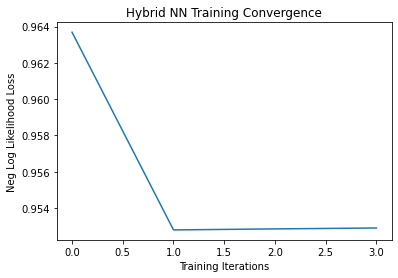

In [69]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [70]:
################ hzr on 12-30-2020 ###################
#This block is for testing on classical computer
######################################################
model.eval()
# 下面的代码不会更新梯度
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
        output = model(quantum_matrix,False,True)
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


Performance on test data:
	Loss: 0.0217
	Accuracy: 83.7%


model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)
model.theta: Parameter containing:
tensor([1.0472, 0.7854, 1.0472, 0.3491, 3.1416, 0.7854, 0.3142, 1.5708],
       dtype=torch.float64, requires_grad=True)


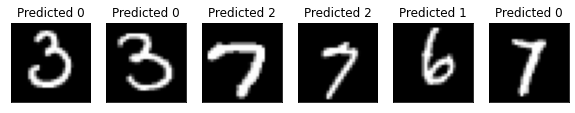

In [71]:
################ hzr on 12-30-2020 ###################
#This block is for testing on quantum computer.
######################################################
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
        output = model(quantum_matrix,False,False)        
        pred = output.argmax(dim=1, keepdim=True) 
        print ("model.theta:",model.theta)

        # output = model(quantum_matrix,False,True)        
        # pred = output.argmax(dim=1, keepdim=True) 


        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1
